<a href="https://colab.research.google.com/github/deepakr82/AIML-Caps-Prj-Grp6-I-NLP/blob/master/NLP_Capstone_IT_Ticket_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIML Online Capstone - AUTOMATIC TICKET ASSIGNMENT

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Load data and Pre-processing


In [1]:
import pandas as pd 
import numpy as np
import sys

In [2]:
# Read the .csv file
Ticket = pd.read_excel('/content/drive/My Drive/AIML/NLP/input_data.xlsx',encoding=sys.getfilesystemencoding())

In [3]:
Ticket.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [4]:
Ticket.drop(columns='Caller',inplace=True)
Ticket.head()

,Short description,Description,Assignment group
0,login issue,-verified user details.(employee# & manager na...,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


In [5]:
Ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Assignment group   8500 non-null   object
dtypes: object(3)
memory usage: 199.3+ KB


In [6]:
#Check for Null and drop null rows - Since null count is less
Ticket.isnull().sum()
Ticket.dropna(inplace=True)
Ticket.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8491 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8491 non-null   object
 1   Description        8491 non-null   object
 2   Assignment group   8491 non-null   object
dtypes: object(3)
memory usage: 265.3+ KB


In [7]:
Ticket.describe()

,Short description,Description,Assignment group
count,8491,8491,8491
unique,7480,7812,74
top,password reset,the,GRP_0
freq,38,56,3968


In [8]:
TargetClass = Ticket['Assignment group'].value_counts()
TargetClass.describe()

count      74.000000
mean      114.743243
std       464.840614
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3968.000000
Name: Assignment group, dtype: float64

Observations:
1. There are 74 Groups in all. The Target class distribution is extremely skewed.
2. GRP_0 has the most number of assignments (3968) accounting for ~50% of the data.
3. There are some groups with 1 ticket assignment as well.

## Option 1 - Use data as is with some groups having less ticket assignments

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


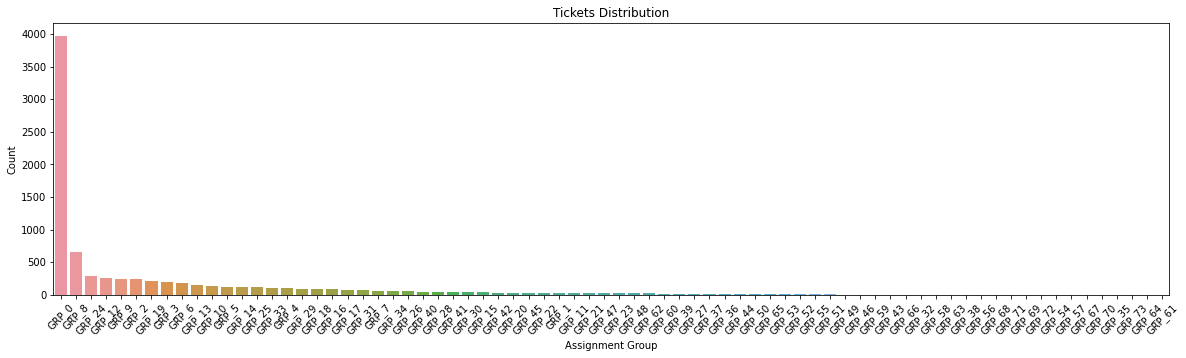

In [9]:
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize = (20,5))

sns.countplot(x='Assignment group', data=Ticket,order = Ticket['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=45)
plt.title('Tickets Distribution')

plt.show()

## Option 2 -  Merge groups with small entries to a group to reduce the imbalance in the target class.

In [10]:
# Group the tickets count < 25 as GRP_A
Ticket1 = pd.DataFrame(Ticket['Assignment group'].value_counts())
Ticket1 = Ticket1.T
Ticket1

,GRP_0,GRP_8,GRP_24,GRP_12,GRP_9,GRP_2,GRP_19,GRP_3,GRP_6,GRP_13,GRP_10,GRP_5,GRP_14,GRP_25,GRP_33,GRP_4,GRP_29,GRP_18,GRP_16,GRP_17,GRP_31,GRP_7,GRP_34,GRP_26,GRP_40,GRP_28,GRP_41,GRP_30,GRP_15,GRP_42,GRP_20,GRP_45,GRP_22,GRP_1,GRP_11,GRP_21,GRP_47,GRP_23,GRP_48,GRP_62,GRP_60,GRP_39,GRP_27,GRP_37,GRP_36,GRP_44,GRP_50,GRP_65,GRP_53,GRP_52,GRP_55,GRP_51,GRP_49,GRP_46,GRP_59,GRP_43,GRP_66,GRP_32,GRP_58,GRP_63,GRP_38,GRP_56,GRP_68,GRP_71,GRP_69,GRP_72,GRP_54,GRP_57,GRP_67,GRP_70,GRP_35,GRP_73,GRP_64,GRP_61
Assignment group,3968,661,289,257,252,241,215,200,184,145,140,129,118,116,107,100,97,88,85,81,69,68,61,56,45,44,40,39,39,37,36,35,31,31,30,29,27,25,25,25,20,19,18,16,15,15,14,11,11,9,8,8,6,6,6,5,4,4,3,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1


In [11]:
Ticket['Count'] = Ticket.apply(lambda row: Ticket1[row['Assignment group']] , axis=1)
Ticket.loc[Ticket['Count'] <= 25 , "Assignment group"] = "GRP_A"

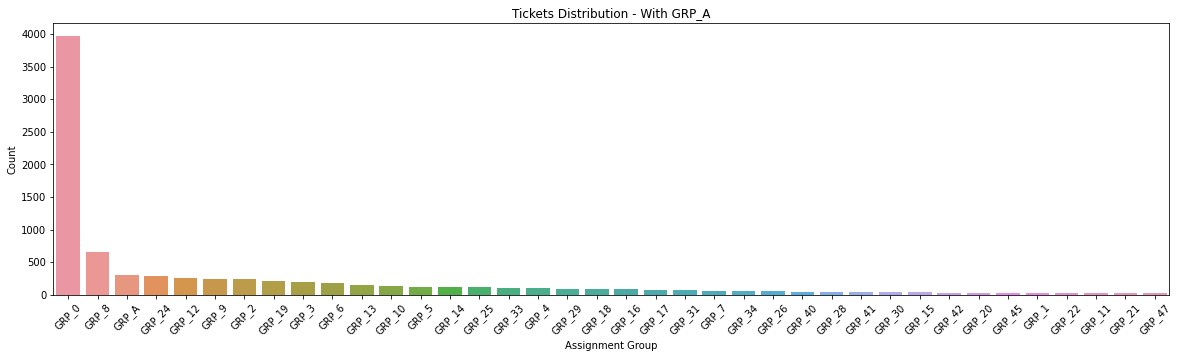

In [12]:
plt.subplots(figsize = (20,5))

sns.countplot(x='Assignment group', data=Ticket,order = Ticket['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=45)
plt.title('Tickets Distribution - With GRP_A')

plt.show()

# Data Cleansing

In [13]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

In [14]:
nltk.download('stopwords')
stop = set(stopwords.words('english')) 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
lemmatizer = WordNetLemmatizer()

In [16]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [17]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [18]:
temp =[]
for sentence in Ticket["Description"]:
    sentence = sentence.lower()
    #sentence = sentence.str.replace('\d+', '')
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'\S+@\S+', 'EmailId', sentence)
    sentence = re.sub(r'\'', '', sentence, re.I|re.A)
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
    sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'com ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)
    l_sentence = lemmatize_sentence(sentence)

    words = [word for word in l_sentence.split() if word not in stopwords.words('english')]
    temp.append(words)

In [20]:
Ticket["Lemmatized_clean"] = temp

In [21]:
Ticket2 = Ticket[Ticket['Lemmatized_clean'].map(lambda d: len(d)) > 0]